<a href="https://colab.research.google.com/github/himanshu-tawra/COVID-19-Detector-Flask-App-from-Chest-X-ray-Images-with-Keras-and-Deep-Learning/blob/master/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import os
from keras import applications
import keras

In [3]:
IMAGE_SIZE = [224,224]

In [4]:
xception = applications.Xception(input_shape= IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

83689472/83683744 [==============================] - 0s 0us/step


In [5]:
for layer in xception.layers:
  layer.trainable = False

In [6]:
xception_output = xception.output

In [7]:
flatten = Flatten()(xception_output)
Dense_layer1 = Dense(units = 256,activation=keras.layers.LeakyReLU(alpha=0.3))(flatten)
Dense_layer2 = Dense(units=128,activation=keras.layers.LeakyReLU(alpha=0.3))(Dense_layer1)
Dense_layer3 = Dense(units = 64,activation=keras.layers.LeakyReLU(alpha=0.3))(Dense_layer2)
output_layer = Dense(3,activation='softmax')(Dense_layer3)

In [8]:
model = Model(inputs = xception.input,outputs = output_layer)

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(0.000001),  # Low learning rate
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
training_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [12]:
val_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [13]:
training_set = training_data_gen.flow_from_directory(
    '/content/drive/My Drive/Data/train/',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = 32
)

Found 1380 images belonging to 3 classes.


In [14]:
val_set = val_data_gen.flow_from_directory(
    '/content/drive/My Drive/Data/test/',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = 32
)

Found 353 images belonging to 3 classes.


In [15]:
from keras.callbacks import ModelCheckpoint
callback_list = [ModelCheckpoint('final_xception_new.h5', monitor='val_loss', verbose=True, save_best_only=True)]

In [16]:
r = model.fit(
    training_set,
    epochs = 100,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch = len(training_set),
    callbacks = callback_list
)

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.9004 - accuracy: 0.6167 
Epoch 00001: val_loss improved from inf to 0.55322, saving model to final_xception_new.h5
44/44 [==============================] - 612s 14s/step - loss: 0.9004 - accuracy: 0.6167 - val_loss: 0.5532 - val_accuracy: 0.8697
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.8449
Epoch 00002: val_loss improved from 0.55322 to 0.34594, saving model to final_xception_new.h5
44/44 [==============================] - 68s 2s/step - loss: 0.4844 - accuracy: 0.8449 - val_loss: 0.3459 - val_accuracy: 0.9065
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8696
Epoch 00003: val_loss improved from 0.34594 to 0.28708, saving model to final_xception_new.h5
44/44 [==============================] - 67s 2s/step - loss: 0.3492 - accuracy: 0.8696 - val_loss: 0.2871 - val_accuracy: 0.9122
Epoch 4/100
44/44 [============================

In [62]:
test_pred = []
test_actual = []
train_pred = []
train_actual = []
label_dict = {
    0 : "Covid",
    1 : "Normal",
    2 : "Pneumonia"
}
train_covid_path = '/content/drive/My Drive/Data/train/COVID19'
train_normal_path = '/content/drive/My Drive/Data/train/NORMAL'
train_pneumonia_path = '/content/drive/My Drive/Data/train/PNEUMONIA'


covid_path = '/content/drive/My Drive/Data/test/COVID19'
normal_path = '/content/drive/My Drive/Data/test/NORMAL'
pneumonia_path = '/content/drive/My Drive/Data/test/PNEUMONIA'

In [63]:
model.evaluate_generator(training_set,steps = 32,verbose = 1)

32/32 [==============================] - 41s 1s/step - loss: 0.0431 - accuracy: 0.9893


[0.04307236894965172, 0.9892578125]

In [64]:
model.evaluate_generator(val_set,steps = 32, verbose = 1)

12/32 [==========>...................] - 10s 835ms/step - loss: 0.1410 - accuracy: 0.9490


[0.14104655385017395, 0.9490085244178772]

In [65]:
def image_preprocessing(test_image):
  image_array = image.img_to_array(test_image)
  image_array = np.expand_dims(image_array,axis = 0)
  rescaled_image = image_array/255. 
  return rescaled_image

def predict_image(path):
  for filename in os.listdir(path):
    filepath = os.path.join(path,filename)
    test_image = image.load_img(filepath,target_size=(224,224))
    rescaled_image = image_preprocessing(test_image)


    predicted_image = model.predict(rescaled_image)
    predicted_image = predicted_image.argmax()
    if path == train_covid_path:
      train_pred.append(predicted_image)
      train_actual.append(0)
    elif path == covid_path:
      test_pred.append(predicted_image)
      test_actual.append(0)
    elif path == train_normal_path:
      train_pred.append(predicted_image)
      train_actual.append(1)
    elif path == normal_path:
      test_pred.append(predicted_image)
      test_actual.append(1)
    elif path == train_pneumonia_path:
      train_pred.append(predicted_image)
      train_actual.append(2)
    elif path == pneumonia_path:
      test_pred.append(predicted_image)
      test_actual.append(2)


In [66]:
predict_image(train_covid_path)
predict_image(train_normal_path)
predict_image(train_pneumonia_path)

predict_image(covid_path)
predict_image(normal_path)
predict_image(pneumonia_path)

In [67]:
test_pred = np.array(test_pred)
test_actual = np.array(test_actual)

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
testing_confusion_mat = confusion_matrix(test_actual,test_pred)
training_confusion_mat = confusion_matrix(train_actual,train_pred)
print(testing_confusion_mat)
print(training_confusion_mat)

[[112   0   4]
 [  0 110   6]
 [  0   8 113]]
[[458   0   2]
 [  0 459   1]
 [  0  15 445]]


In [69]:
import matplotlib.pyplot as plt
import seaborn

In [70]:
def plot_confusion_matrix(confusion_mat,fig_name):

  classes = ['COVID','NORMAL','PNEUMONIA']
  tick_marks = [0.5,1.5,2.5]
  sns.heatmap(confusion_mat,cmap='plasma',annot=True,linewidth = 2,fmt = 'd')

  plt.xticks(tick_marks, classes,rotation ='vertical')
  plt.yticks(tick_marks, classes,rotation ='vertical')
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(fig_name + '.png')
  plt.margins(0.2) 

  plt.show()

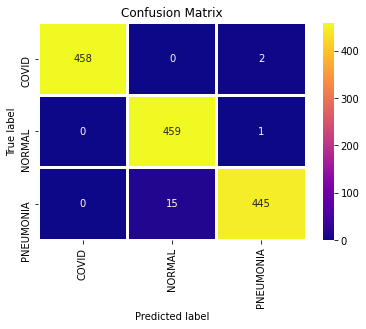

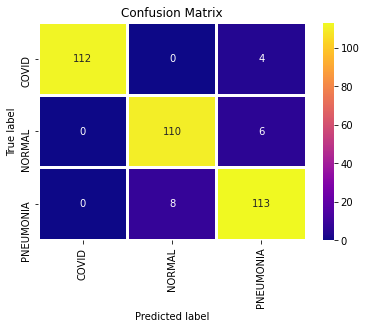

In [71]:
plot_confusion_matrix(training_confusion_mat,'Training_Confusion_Matrix')
plot_confusion_matrix(testing_confusion_mat,'Testing_Confusion_Matrix')

In [72]:
from sklearn.metrics import classification_report
print(classification_report(train_actual, train_pred,labels = [0,1,2],target_names=["Covid","Normal","Pneumonia"]))
print(classification_report(test_actual, test_pred,labels = [0,1,2],target_names=["Covid","Normal","Pneumonia"]))


              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       460
      Normal       0.97      1.00      0.98       460
   Pneumonia       0.99      0.97      0.98       460

    accuracy                           0.99      1380
   macro avg       0.99      0.99      0.99      1380
weighted avg       0.99      0.99      0.99      1380

              precision    recall  f1-score   support

       Covid       1.00      0.97      0.98       116
      Normal       0.93      0.95      0.94       116
   Pneumonia       0.92      0.93      0.93       121

    accuracy                           0.95       353
   macro avg       0.95      0.95      0.95       353
weighted avg       0.95      0.95      0.95       353



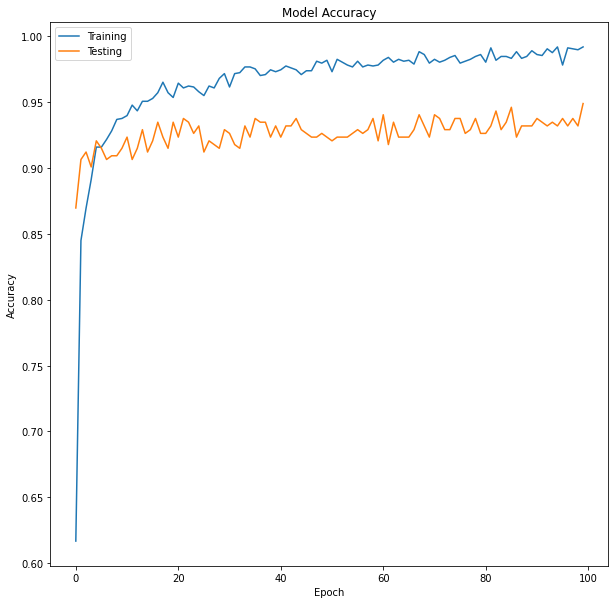

In [73]:

plt.figure(figsize=(10,10))

plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_accuracy.png')
plt.show()

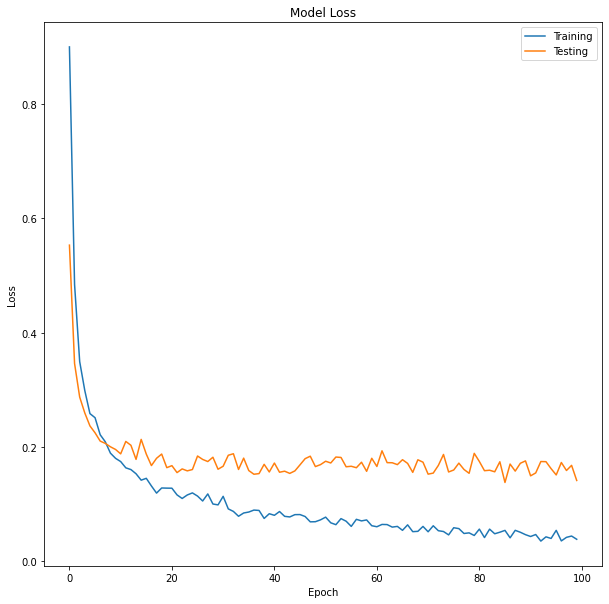

In [74]:
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_loss.png')
plt.show()

In [75]:
from keras.utils import plot_model

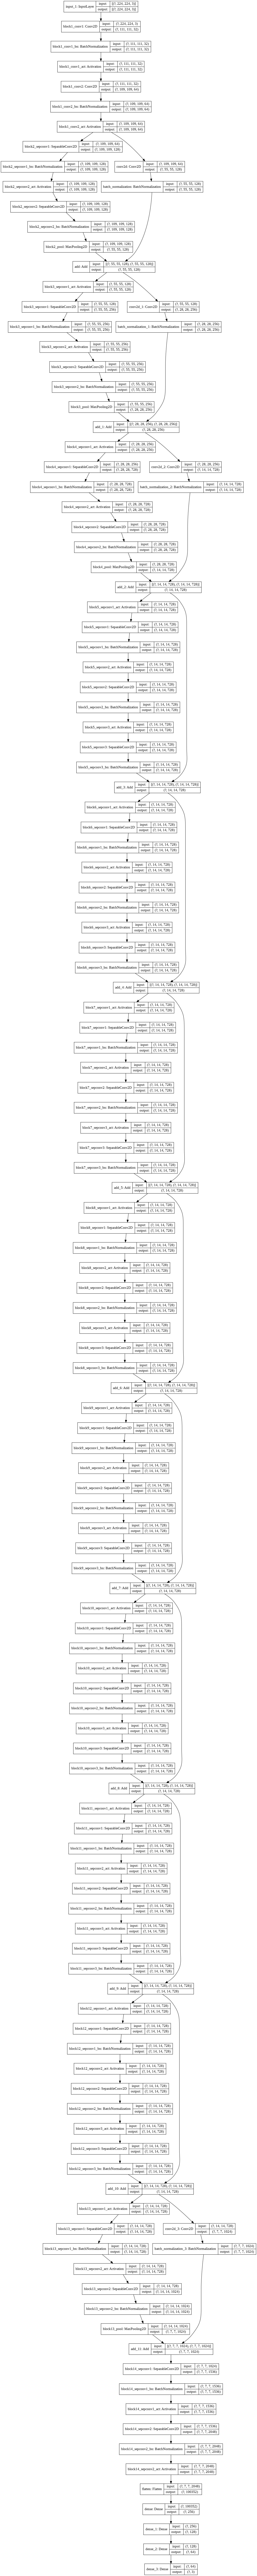

In [76]:
plot_model(model, show_shapes=True, to_file='model__xception.png')


In [ ]:
print(np.array(test_actual).shape)

In [ ]:
print(train_pred)

['Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 

In [ ]:
model.save('final_xception_model.h5')